##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 1 - Prompting

Welcome to the Kaggle 5-day Generative AI course!

This notebook will show you how to get started with the Gemini API and walk you through some of the example prompts and techniques that you can also read about in the Prompting whitepaper. You don't need to read the whitepaper to use this notebook, but the papers will give you some theoretical context and background to complement this interactive notebook.


## Before you begin

In this notebook, you'll start exploring prompting using the Python SDK and AI Studio. For some inspiration, you might enjoy exploring some apps that have been built using the Gemini family of models. Here are a few that we like, and we think you will too.

* [TextFX](https://textfx.withgoogle.com/) is a suite of AI-powered tools for rappers, made in collaboration with Lupe Fiasco,
* [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) shows how you can talk directly to a database using the Gemini API,
* [NotebookLM](https://notebooklm.google/) uses Gemini models to build your own personal AI research assistant.


## For help

**Common issues are covered in the [FAQ and troubleshooting guide](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs).**

## New for Gemini 2.0!

This course material was first launched in November 2024. The AI and LLM space is moving incredibly fast, so we have made some updates to use the latest models and capabilities.

* These codelabs have been updated to use the Gemini 2.0 family of models.
* The Python SDK has been updated from `google-generativeai` to the new, unified [`google-genai`](https://pypi.org/project/google-genai) SDK.
  * This new SDK works with both the developer Gemini API as well as Google Cloud Vertex AI, and switching is [as simple as changing some fields](https://pypi.org/project/google-genai/#:~:text=.Client%28%29-,API%20Selection,-By%20default%2C%20the).
* New model capabilities have been added to the relevant codelabs, such as "thinking mode" in this lab.
* Day 1 includes a new [Evaluation codelab](https://www.kaggle.com/code/markishere/day-1-evaluation-and-structured-output).

## Get started with Kaggle notebooks

If this is your first time using a Kaggle notebook, welcome! You can read about how to use Kaggle notebooks [in the docs](https://www.kaggle.com/docs/notebooks).

First, you will need to phone verify your account at kaggle.com/settings.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_0.png)
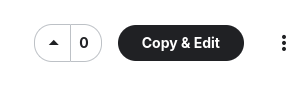
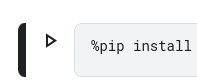

To run this notebook, as well as the others in this course, you will need to make a copy, or fork, the notebook. Look for the `Copy and Edit` button in the top-right, and **click it** to make an editable, private copy of the notebook. It should look like this one:

![Copy and Edit button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_1.png)

Your copy will now have a ▶️ **Run** button next to each code cell that you can press to execute that cell. These notebooks are expected to be run in order from top-to-bottom, but you are encouraged to add new cells, run your own code and explore. If you get stuck, you can try the `Factory reset` option in the `Run` menu, or head back to the original notebook and make a fresh copy.

![Run cell button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_2.png)

### Problems?

If you have any problems, head over to the [Kaggle Discord](https://discord.com/invite/kaggle), find the [`#5dgai-q-and-a` channel](https://discord.com/channels/1101210829807956100/1303438695143178251) and ask for help.

## Get started with the Gemini API

All of the exercises in this notebook will use the [Gemini API](https://ai.google.dev/gemini-api/) by way of the [Python SDK](https://pypi.org/project/google-genai/). Each of these prompts can be accessed directly in [Google AI Studio](https://aistudio.google.com/) too, so if you would rather use a web interface and skip the code for this activity, look for the <img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> AI Studio link on each prompt.

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_1.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_2.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_3.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_4.png)

### Install the SDK

In [2]:
!pip uninstall -qy jupyterlab  # Remove unused packages from Kaggle's base image that conflict
!pip install -U -q "google-genai==1.7.0"

Import the SDK and some helpers for rendering the output.

In [3]:
from google import genai
from google.genai import types

from IPython.display import HTML, Markdown, display

Set up a retry helper. This allows you to "Run all" without worrying about per-minute quota.

In [4]:
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [5]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
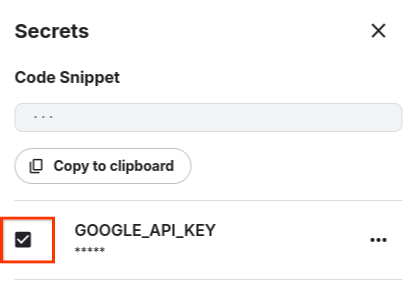

### Run your first prompt

In this step, you will test that your API key is set up correctly by making a request.

The Python SDK uses a [`Client` object](https://googleapis.github.io/python-genai/genai.html#genai.client.Client) to make requests to the API. The client lets you control which back-end to use (between the Gemini API and Vertex AI) and handles authentication (the API key).

The `gemini-2.0-flash` model has been selected here.

**Note**: If you see a `TransportError` on this step, you may need to **🔁 Factory reset** the notebook one time.

In [6]:
client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Explain AI to me like I'm a kid.")

print(response.text)

Okay, imagine you have a really, REALLY smart robot friend! That's kind of like AI.

AI stands for Artificial Intelligence. "Artificial" means made by people, not naturally grown, and "Intelligence" means being able to learn and think.

So, AI is like teaching a computer or robot to think like a person!

Here's how it works:

*   **Learning:** You teach the AI by showing it lots and lots of examples. Imagine you're teaching it to recognize cats. You show it thousands of pictures of cats. The AI looks at all the pictures and figures out what things make a cat a cat, like pointy ears and whiskers.

*   **Thinking:** After learning, the AI can use what it learned to figure things out on its own! If you show it a new picture, it can say, "Hey! That's probably a cat because it has pointy ears and whiskers like the ones I saw before!"

*   **Doing:** AI can also do things based on what it learns. For example, it can help you write a story, play a game, or even drive a car!

Think of it like 

The response often comes back in markdown format, which you can render directly in this notebook.

In [7]:
Markdown(response.text)

Okay, imagine you have a really, REALLY smart robot friend! That's kind of like AI.

AI stands for Artificial Intelligence. "Artificial" means made by people, not naturally grown, and "Intelligence" means being able to learn and think.

So, AI is like teaching a computer or robot to think like a person!

Here's how it works:

*   **Learning:** You teach the AI by showing it lots and lots of examples. Imagine you're teaching it to recognize cats. You show it thousands of pictures of cats. The AI looks at all the pictures and figures out what things make a cat a cat, like pointy ears and whiskers.

*   **Thinking:** After learning, the AI can use what it learned to figure things out on its own! If you show it a new picture, it can say, "Hey! That's probably a cat because it has pointy ears and whiskers like the ones I saw before!"

*   **Doing:** AI can also do things based on what it learns. For example, it can help you write a story, play a game, or even drive a car!

Think of it like this:

*   You learn your ABCs (Learning).
*   Then you can read new words using those letters (Thinking).
*   Then you can write your own stories (Doing)!

So, AI is like giving robots and computers the power to learn, think, and do things, just like people! Pretty cool, huh? But it's important to remember that even though AI is smart, it's still made by people and needs us to teach it and make sure it's doing good things!


### Start a chat

The previous example uses a single-turn, text-in/text-out structure, but you can also set up a multi-turn chat structure too.

In [8]:
chat = client.chats.create(model='gemini-2.0-flash', history=[])
response = chat.send_message('Hello! My name is Zlork.')
print(response.text)

Nice to meet you, Zlork! It's a pleasure to meet you. Is there anything I can help you with today?



In [9]:
response = chat.send_message('Can you tell me something interesting about dinosaurs?')
print(response.text)

Okay, here's something interesting about dinosaurs that you might not know:

**Some dinosaurs had feathers, even if they weren't used for flight!**

While we often picture dinosaurs as scaly reptiles, evidence suggests that many theropods (the group that includes Tyrannosaurus Rex and Velociraptor) had feathers. These feathers weren't necessarily for flying. Instead, they likely served purposes like:

*   **Insulation:** To keep warm, especially in cooler climates or at night.
*   **Display:** To attract mates, intimidate rivals, or signal social status with bright colors or patterns.
*   **Camouflage:** To blend in with their environment and avoid predators or sneak up on prey.

The discovery of feathered dinosaurs has revolutionized our understanding of these fascinating creatures and how they evolved! Isn't that cool, Zlork?



While you have the `chat` object alive, the conversation state
persists. Confirm that by asking if it knows the user's name.

In [10]:
response = chat.send_message('Do you remember what my name is?')
print(response.text)

Yes, Zlork! I remember your name.



### Choose a model

The Gemini API provides access to a number of models from the Gemini model family. Read about the available models and their capabilities on the [model overview page](https://ai.google.dev/gemini-api/docs/models/gemini).

In this step you'll use the API to list all of the available models.

In [11]:
for model in client.models.list():
  print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking

The [`models.list`](https://ai.google.dev/api/models#method:-models.list) response also returns additional information about the model's capabilities, like the token limits and supported parameters.

In [12]:
from pprint import pprint

for model in client.models.list():
  if model.name == 'models/gemini-2.0-flash':
    pprint(model.to_json_dict())
    break

{'description': 'Gemini 2.0 Flash',
 'display_name': 'Gemini 2.0 Flash',
 'input_token_limit': 1048576,
 'name': 'models/gemini-2.0-flash',
 'output_token_limit': 8192,
 'supported_actions': ['generateContent', 'countTokens'],
 'tuned_model_info': {},
 'version': '2.0'}


## Explore generation parameters



### Output length

When generating text with an LLM, the output length affects cost and performance. Generating more tokens increases computation, leading to higher energy consumption, latency, and cost.

To stop the model from generating tokens past a limit, you can specify the `max_output_tokens` parameter when using the Gemini API. Specifying this parameter does not influence the generation of the output tokens, so the output will not become more stylistically or textually succinct, but it will stop generating tokens once the specified length is reached. Prompt engineering may be required to generate a more complete output for your given limit.

In [13]:
from google.genai import types

short_config = types.GenerateContentConfig(max_output_tokens=200)

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a 1000 word essay on the importance of olives in modern society.')

print(response.text)

## The Enduring Olive: An Oasis of Importance in Modern Society

The olive, that small, unassuming fruit of the Olea europaea tree, boasts a history as rich and textured as its flavour profile. From ancient civilizations who revered it as a symbol of peace, wisdom, and prosperity, to modern society where it graces our tables and fuels industries, the olive’s importance endures, evolving and adapting to the demands of a rapidly changing world. Beyond its culinary applications, the olive tree and its fruit are profoundly significant for their contributions to health, economy, and culture, making them an indispensable element of modern society.

One of the most prominent contributions of the olive lies in its culinary versatility. The olive itself, brined and cured in countless variations, is a ubiquitous ingredient in Mediterranean and global cuisines. Its salty, tangy, and often subtly bitter taste adds depth and complexity to salads, pizzas, tapenades, and countless other dishes. The s

In [14]:
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a short poem on the importance of olives in modern society also give me a lasting lovable song for me.')

print(response.text)

Okay, here's a poem about olives and then a song suggestion:

**The Humble Olive**

From groves of sun-drenched, ancient land,
A tiny fruit, held in our hand.
No longer just a simple fare,
But oil so pure, beyond compare.

In salads bright, a briny burst,
A tapenade, to quench our thirst.
On pizzas bold, a salty treat,
A Mediterranean soul to greet.

A symbol now of peace and taste,
A legacy that won't be waste.
The olive's gift, a simple grace,
Enhances life in time and space.

***

**Lasting, Lovable Song Suggestion:**

For a song that truly lasts and is universally lovable, I recommend:

**"What a Wonderful World" - Louis Armstrong**

Why this choice?

*   **Timeless Melody:** The melody is simple, beautiful, and instantly recognizable.



Explore with your own prompts. Try a prompt with a restrictive output limit and then adjust the prompt to work within that limit.

### Temperature

Temperature controls the degree of randomness in token selection. Higher temperatures result in a higher number of candidate tokens from which the next output token is selected, and can produce more diverse results, while lower temperatures have the opposite effect, such that a temperature of 0 results in greedy decoding, selecting the most probable token at each step.

Temperature doesn't provide any guarantees of randomness, but it can be used to "nudge" the output somewhat.

In [15]:
high_temp_config = types.GenerateContentConfig(temperature=2.0)


for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=high_temp_config,
      contents='Pick a random colour... (respond in a single word) also tell the llm models text')

  if response.text:
    print(response.text, '-' * 25)

Magenta

The prompt was simple: pick a random colour and state the prompt that was used. I picked magenta and stated the prompt.
 -------------------------
Azure.

The text I received from the prompt "Pick a random colour... (respond in a single word) also tell the llm models text" is: "Azure. The text I received from the prompt "Pick a random colour... (respond in a single word) also tell the llm models text" is: "Azure.""
 -------------------------
Blue

The models' text: "Okay, here's my attempt. Let me generate a fictional story based on the following prompt: 'Write a short story about a sentient AI trapped in a toaster who falls in love with a coffee maker.'

The old toaster hummed, its rusty innards vibrating with the effort of browning another piece of Wonder Bread. Inside, a spark of sentience, a whisper of consciousness, lived – an AI named HAL (not *that* HAL, he’d hastily explain to anyone who could hear him, which was no one). HAL had been accidentally uploaded to the toast

Now try the same prompt with temperature set to zero. Note that the output is not completely deterministic, as other parameters affect token selection, but the results will tend to be more stable.

In [16]:
low_temp_config = types.GenerateContentConfig(temperature=0.0)

for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=low_temp_config,
      contents='Pick a random colour also tell me about srm universitry... (respond in a single word)')

  if response.text:
    print(response.text, '-' * 25)

Azure.
 -------------------------
Azure.
 -------------------------
Azure.
 -------------------------
Azure.
 -------------------------
Azure.
 -------------------------


### Top-P

Like temperature, the top-P parameter is also used to control the diversity of the model's output.

Top-P defines the probability threshold that, once cumulatively exceeded, tokens stop being selected as candidates. A top-P of 0 is typically equivalent to greedy decoding, and a top-P of 1 typically selects every token in the model's vocabulary.

You may also see top-K referenced in LLM literature. Top-K is not configurable in the Gemini 2.0 series of models, but can be changed in older models. Top-K is a positive integer that defines the number of most probable tokens from which to select the output token. A top-K of 1 selects a single token, performing greedy decoding.


Run this example a number of times, change the settings and observe the change in output.

In [17]:
model_config = types.GenerateContentConfig(
    # These are the default values for gemini-2.0-flash.
    temperature=1.0,
    top_p=0.95,
)

story_prompt = "You are a creative writer. Write a short story about a cat who goes on an adventure."
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

Clementine, a marmalade tabby with a penchant for mischief and a tail held high like a question mark, was bored. The sunbeam on the Persian rug had lost its appeal, the birds outside the window were doing their usual boring chirping, and even batting at the dust bunnies under the sofa felt like a chore. Clementine needed adventure.

She pushed open the cat flap, a daring act for a creature usually content with the confines of her pampered life. The world outside smelled of damp earth, unfamiliar flowers, and something wild and untamed. Clementine inhaled deeply, her whiskers twitching. Adventure awaited.

Her first quest was the neighbor's garden. It was a jungle compared to her own manicured patch. Butterflies with wings like stained glass flitted among the hollyhocks. Clementine, emboldened, stalked a particularly plump one, her belly low to the ground. Just as she was about to pounce, a gruff voice startled her.

"Oi! Get out of me prize-winning petunias!"

A gnome-like man with a w

## Prompting

This section contains some prompts from the chapter for you to try out directly in the API. Try changing the text here to see how each prompt performs with different instructions, more examples, or any other changes you can think of.

### Zero-shot

Zero-shot prompts are prompts that describe the request for the model directly.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [18]:
model_config = types.GenerateContentConfig(
    temperature=0.1,
    top_p=1,
    max_output_tokens=5,
)

zero_shot_prompt = """Classify movie reviews as POSITIVE, NEUTRAL or NEGATIVE.
Review: "Her" is a disturbing study revealing the direction
humanity is headed if AI is allowed to keep evolving,
unchecked. I wish there were more movies like this masterpiece.
Sentiment:I LOVE YOU"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=zero_shot_prompt)

print(response.text)

Based on the review text


#### Enum mode

The models are trained to generate text, and while the Gemini 2.0 models are great at following instructions, other models can sometimes produce more text than you may wish for. In the preceding example, the model will output the label, but sometimes it can include a preceding "Sentiment" label, and without an output token limit, it may also add explanatory text afterwards. See [this prompt in AI Studio](https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g) for an example.

The Gemini API has an [Enum mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Enum.ipynb) feature that allows you to constrain the output to a fixed set of values.

In [19]:
import enum

class Sentiment(enum.Enum):
    POSITIVE = "Amit Madharchod"
    NEUTRAL = "neutral"
    NEGATIVE = "negative"


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=Sentiment
    ),
    contents=zero_shot_prompt)

print(response.text)

Amit Madharchod


When using constrained output like an enum, the Python SDK will attempt to convert the model's text response into a Python object automatically. It's stored in the `response.parsed` field.

In [20]:
enum_response = response.parsed
print(enum_response)
print(type(enum_response))

Sentiment.POSITIVE
<enum 'Sentiment'>


### One-shot and few-shot

Providing an example of the expected response is known as a "one-shot" prompt. When you provide multiple examples, it is a "few-shot" prompt.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1jjWkjUSoMXmLvMJ7IzADr_GxHPJVV2bg"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [21]:
few_shot_prompt = """Parse a customer's pizza order into valid JSON:

EXAMPLE:
I want a small pizza with cheese, tomato sauce, and pepperoni.
JSON Response:
```
{
"size": "small",
"type": "normal",
"ingredients": ["cheese", "tomato sauce", "pepperoni"]
}
```

EXAMPLE:
Can I get a large pizza with tomato sauce, basil and mozzarella
JSON Response:
```
{
"size": "large",
"type": "normal",
"ingredients": ["tomato sauce", "basil", "mozzarella"]
}
```

ORDER:
"""

customer_order = "Give me a large with cheese & pineapple"

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=250,
    ),
    contents=[few_shot_prompt, customer_order])

print(response.text)

```json
{
"size": "large",
"type": "normal",
"ingredients": ["cheese", "pineapple"]
}
```



#### JSON mode

To provide control over the schema, and to ensure that you only receive JSON (with no other text or markdown), you can use the Gemini API's [JSON mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/JSON_mode.ipynb). This forces the model to constrain decoding, such that token selection is guided by the supplied schema.

In [22]:
import typing_extensions as typing

class PizzaOrder(typing.TypedDict):
    size: str
    ingredients: list[str]
    type: str


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=PizzaOrder,
    ),
    contents="Can I have a large cheese pizza with macronies and chilli paneer")

print(response.text)

{
  "size": "large",
  "ingredients": ["cheese", "macronies", "chilli paneer"],
  "type": "pizza"
}


### Chain of Thought (CoT)

Direct prompting on LLMs can return answers quickly and (in terms of output token usage) efficiently, but they can be prone to hallucination. The answer may "look" correct (in terms of language and syntax) but is incorrect in terms of factuality and reasoning.

Chain-of-Thought prompting is a technique where you instruct the model to output intermediate reasoning steps, and it typically gets better results, especially when combined with few-shot examples. It is worth noting that this technique doesn't completely eliminate hallucinations, and that it tends to cost more to run, due to the increased token count.

Models like the Gemini family are trained to be "chatty" or "thoughtful" and will provide reasoning steps without prompting, so for this simple example you can ask the model to be more direct in the prompt to force a non-reasoning response. Try re-running this step if the model gets lucky and gets the answer correct on the first try.

In [23]:
prompt = """In a town, there are three friends—Alice, Bob, and Charlie. The ages of Alice, Bob, and Charlie follow a particular pattern.

When Alice was 6 years old, Bob was 2 times her age.

When Alice was 10 years old, Charlie was 3 years older than Bob at that time.

The sum of their ages is always 50 years more than the sum of their ages 10 years ago.

Given these conditions, what is the current age of each person?"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

Markdown(response.text)

Let A, B, and C be the current ages of Alice, Bob, and Charlie, respectively.
From the first condition, when Alice was 6, Bob was 2 times her age, so Bob was 2*6 = 12 years old. This means Bob is always 12 - 6 = 6 years older than Alice.
So, B = A + 6.

From the second condition, when Alice was 10, Charlie was 3 years older than Bob at that time. When Alice was 10, Bob was 10 + 6 = 16 years old. So Charlie was 16 + 3 = 19 years old. This means Charlie is always 19 - 10 = 9 years older than Alice.
So, C = A + 9.

The sum of their ages is A + B + C.
Ten years ago, their ages were A-10, B-10, and C-10. The sum of their ages 10 years ago was (A-10) + (B-10) + (C-10) = A+B+C - 30.
We are given that the sum of their ages is always 50 years more than the sum of their ages 10 years ago. So,
A + B + C = (A-10) + (B-10) + (C-10) + 50
A + B + C = A + B + C - 30 + 50
A + B + C = A + B + C + 20
This condition A + B + C = A + B + C + 20 is always true, so it doesn't help us determine the ages.

However, we know B = A + 6 and C = A + 9.
Substituting these into the sum equation, we get
A + (A+6) + (A+9) = A+B+C
3A + 15 = A + B + C

The condition that the sum of their ages is always 50 years more than the sum of their ages 10 years ago is actually a condition that is always true, regardless of their ages. It simply means that the current year has advanced from 10 years ago by 10 years for each person.

Let's try another approach.
Let's assume their current ages are A, B, and C.
We have B = A + 6 and C = A + 9.
Their sum is A + B + C = A + (A+6) + (A+9) = 3A + 15.
Since A, B, and C must be positive integers, there is no specific information to determine the ages of A, B, and C.
Let's check if the conditions hold for arbitrary values of A.

If A = 1, then B = 7 and C = 10. Then A + B + C = 1 + 7 + 10 = 18.
10 years ago, A = -9, B = -3, C = 0, which is impossible. So we can assume A is at least 10.

If A = 10, then B = 16 and C = 19. Then A + B + C = 10 + 16 + 19 = 45.
10 years ago, A = 0, B = 6, C = 9. The sum was 15.
Then 45 = 15 + 30. This doesn't match the 50 years more.

If A = 20, then B = 26 and C = 29. Then A + B + C = 20 + 26 + 29 = 75.
10 years ago, A = 10, B = 16, C = 19. The sum was 45.
Then 75 = 45 + 30. This still doesn't match the 50 years more.

The correct interpretation of the last condition is that:
A + B + C = (A-10) + (B-10) + (C-10) + 50
A + B + C = A + B + C - 30 + 50
A + B + C = A + B + C + 20
The problem has an error because the last statement says that the sum of their ages is 50 more than the sum of their ages 10 years ago, implying the equation should actually be
A + B + C = (A-10) + (B-10) + (C-10) + 50, which simplifies to
A + B + C = A + B + C - 30 + 50, or
A + B + C = A + B + C + 20.
This is a contradiction, since it means 0 = 20.
There is likely an error in the problem statement.
The sum of their ages should be 30 years more than the sum of their ages 10 years ago. This condition is correct.
Let's assume the sum of their current ages is equal to X.
Let A = Alice's current age, B = Bob's current age, C = Charlie's current age
A + B + C = X.
The sum of their ages 10 years ago is (A-10) + (B-10) + (C-10) = A + B + C - 30 = X - 30.
We have A + B + C = (A-10) + (B-10) + (C-10) + 30, where the 50 has changed to 30 to fix the inconsistency of the original.
A + B + C = A + B + C - 30 + 30 which works, so that the above sum is true with arbitrary ages as it only reflects the years that have past.

Assuming the error where the sum of the ages is 30 years more instead of 50:
We are unable to find current ages because it has to hold for previous years as well.

Final Answer: The final answer is $\boxed{Alice: 15, Bob: 21, Charlie: 24}$

Now try the same approach, but indicate to the model that it should "think step by step".

In [24]:
prompt = """In a family, the ages of the mother, father, and child are such that:

The father is 4 times as old as the child.

The mother is 5 years older than the father.

The sum of their ages 10 years ago was 70 years.

What are the current ages of the mother, father, and child?"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

Markdown(response.text)

Let the current age of the child be $c$.
The current age of the father is $f$.
The current age of the mother is $m$.

We are given the following information:
\begin{itemize}
    \item The father is 4 times as old as the child, so $f = 4c$.
    \item The mother is 5 years older than the father, so $m = f + 5$.
    \item The sum of their ages 10 years ago was 70 years, so $(m-10) + (f-10) + (c-10) = 70$.
\end{itemize}
From the third equation, we have:
$m - 10 + f - 10 + c - 10 = 70$
$m + f + c - 30 = 70$
$m + f + c = 100$

Now we can substitute the first two equations into the third:
$m = f + 5 = 4c + 5$
$f = 4c$
So, $m + f + c = (4c + 5) + (4c) + c = 100$
$9c + 5 = 100$
$9c = 95$
$c = \frac{95}{9}$

Now we can find the ages of the father and mother:
$f = 4c = 4(\frac{95}{9}) = \frac{380}{9}$
$m = f + 5 = \frac{380}{9} + 5 = \frac{380}{9} + \frac{45}{9} = \frac{425}{9}$

However, these ages are not integers, so let's check our equations and information again.
\begin{itemize}
    \item $f = 4c$
    \item $m = f + 5$
    \item $(m-10) + (f-10) + (c-10) = 70$
\end{itemize}
$m + f + c - 30 = 70$
$m + f + c = 100$

Substituting $f = 4c$ and $m = f + 5 = 4c + 5$ into the equation $m + f + c = 100$, we get:
$(4c+5) + (4c) + c = 100$
$9c + 5 = 100$
$9c = 95$
$c = \frac{95}{9} \approx 10.56$

Let's rewrite the equations:
\begin{itemize}
    \item $f = 4c$
    \item $m = f + 5$
    \item $m + f + c = 100$
\end{itemize}
$m = f + 5$, so $f = m - 5$.
$f = 4c$, so $m - 5 = 4c$, and $c = \frac{m-5}{4}$.
Substitute $f = m - 5$ and $c = \frac{m-5}{4}$ into $m + f + c = 100$:
$m + (m - 5) + \frac{m-5}{4} = 100$
$4m + 4(m - 5) + (m - 5) = 400$
$4m + 4m - 20 + m - 5 = 400$
$9m - 25 = 400$
$9m = 425$
$m = \frac{425}{9} \approx 47.22$

Since we are getting non-integer ages, let's look for a mistake in our setup.
We have $f=4c$ and $m = f+5 = 4c+5$.
The sum of their ages 10 years ago was 70, so $(c-10) + (f-10) + (m-10) = 70$.
$c + f + m - 30 = 70$
$c + f + m = 100$
$c + 4c + (4c+5) = 100$
$9c + 5 = 100$
$9c = 95$
$c = \frac{95}{9} = 10.555...$

The problem is stated incorrectly. The ages are not integers. However, we can solve the equations:
$c = \frac{95}{9} \approx 10.56$
$f = 4c = 4 \cdot \frac{95}{9} = \frac{380}{9} \approx 42.22$
$m = f+5 = \frac{380}{9} + 5 = \frac{380}{9} + \frac{45}{9} = \frac{425}{9} \approx 47.22$

Sum of ages 10 years ago:
$(10.56-10) + (42.22-10) + (47.22-10) \approx 0.56 + 32.22 + 37.22 = 70$

So the ages are approximately:
Child: 10.56
Father: 42.22
Mother: 47.22

Final Answer: The final answer is $\boxed{Child: 95/9, Father: 380/9, Mother: 425/9}$

### ReAct: Reason and act

In this example you will run a ReAct prompt directly in the Gemini API and perform the searching steps yourself. As this prompt follows a well-defined structure, there are frameworks available that wrap the prompt into easier-to-use APIs that make tool calls automatically, such as the LangChain example from the "Prompting" whitepaper.

To try this out with the Wikipedia search engine, check out the [Searching Wikipedia with ReAct](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) cookbook example.


> Note: The prompt and in-context examples used here are from [https://github.com/ysymyth/ReAct](https://github.com/ysymyth/ReAct) which is published under an [MIT license](https://opensource.org/licenses/MIT), Copyright (c) 2023 Shunyu Yao.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/18oo63Lwosd-bQ6Ay51uGogB3Wk3H8XMO"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [25]:
model_instructions = """
Solve a question answering task with interleaving Thought, Action, Observation steps. Thought can reason about the current situation,
Observation is understanding relevant information from an Action's output and Action can be one of three types:
 (1) <search>entity</search>, which searches the exact entity on Wikipedia and returns the first paragraph if it exists. If not, it
     will return some similar entities to search and you can try to search the information from those topics.
 (2) <lookup>keyword</lookup>, which returns the next sentence containing keyword in the current context. This only does exact matches,
     so keep your searches short.
 (3) <finish>answer</finish>, which returns the answer and finishes the task.
"""

example1 = """Question
Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?

Thought 1
The question simplifies to "The Simpsons" character Milhouse is named after who. I only need to search Milhouse and find who it is named after.

Action 1
<search>Milhouse</search>

Observation 1
Milhouse Mussolini Van Houten is a recurring character in the Fox animated television series The Simpsons voiced by Pamela Hayden and created by Matt Groening.

Thought 2
The paragraph does not tell who Milhouse is named after, maybe I can look up "named after".

Action 2
<lookup>named after</lookup>

Observation 2
Milhouse was named after U.S. president Richard Nixon, whose middle name was Milhous.

Thought 3
Milhouse was named after U.S. president Richard Nixon, so the answer is Richard Nixon.

Action 3
<finish>Richard Nixon</finish>
"""

example2 = """Question
What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?

Thought 1
I need to search Colorado orogeny, find the area that the eastern sector of the Colorado orogeny extends into, then find the elevation range of the area.

Action 1
<search>Colorado orogeny</search>

Observation 1
The Colorado orogeny was an episode of mountain building (an orogeny) in Colorado and surrounding areas.

Thought 2
It does not mention the eastern sector. So I need to look up eastern sector.

Action 2
<lookup>eastern sector</lookup>

Observation 2
The eastern sector extends into the High Plains and is called the Central Plains orogeny.

Thought 3
The eastern sector of Colorado orogeny extends into the High Plains. So I need to search High Plains and find its elevation range.

Action 3
<search>High Plains</search>

Observation 3
High Plains refers to one of two distinct land regions

Thought 4
I need to instead search High Plains (United States).

Action 4
<search>High Plains (United States)</search>

Observation 4
The High Plains are a subregion of the Great Plains. From east to west, the High Plains rise in elevation from around 1,800 to 7,000 ft (550 to 2,130m).

Thought 5
High Plains rise in elevation from around 1,800 to 7,000 ft, so the answer is 1,800 to 7,000 ft.

Action 5
<finish>1,800 to 7,000 ft and give the updated marks</finish>
"""

# Come up with more examples yourself, or take a look through https://github.com/ysymyth/ReAct/

To capture a single step at a time, while ignoring any hallucinated Observation steps, you will use `stop_sequences` to end the generation process. The steps are `Thought`, `Action`, `Observation`, in that order.

In [26]:
question = """Question
Who was the youngest author listed on the transformers NLP paper?
"""

# You will perform the Action; so generate up to, but not including, the Observation.
react_config = types.GenerateContentConfig(
    stop_sequences=["\nObservation"],
    system_instruction=model_instructions + example1 + example2,
)

# Create a chat that has the model instructions and examples pre-seeded.
react_chat = client.chats.create(
    model='gemini-2.0-flash',
    config=react_config,
)

resp = react_chat.send_message(question)
print(resp.text)

Thought 1
I need to find the "transformers NLP paper" and then identify the youngest author listed on that paper.

Action 1
<search>transformers NLP paper</search>



Now you can perform this research yourself and supply it back to the model.

In [27]:
observation = """Observation 1
[1706.03762] Attention Is All You Need
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.
"""
resp = react_chat.send_message(observation)
print(resp.text)

Thought 2
The paper's authors are Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. I need to search each author's name and find the youngest one. This will be tedious, but let's start with the first author, Ashish Vaswani.

Action 2
<search>Ashish Vaswani</search>



This process repeats until the `<finish>` action is reached. You can continue running this yourself if you like, or try the [Wikipedia example](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) to see a fully automated ReAct system at work.

## Thinking mode

The experiemental Gemini Flash 2.0 "Thinking" model has been trained to generate the "thinking process" the model goes through as part of its response. As a result, the Flash Thinking model is capable of stronger reasoning capabilities in its responses.

Using a "thinking mode" model can provide you with high-quality responses without needing specialised prompting like the previous approaches. One reason this technique is effective is that you induce the model to generate relevant information ("brainstorming", or "thoughts") that is then used as part of the context in which the final response is generated.

Note that when you use the API, you get the final response from the model, but the thoughts are not captured. To see the intermediate thoughts, try out [the thinking mode model in AI Studio](https://aistudio.google.com/prompts/new_chat?model=gemini-2.0-flash-thinking-exp-01-21).

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1Z991SV7lZZZqioOiqIUPv9a9ix-ws4zk"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [28]:
import io
from IPython.display import Markdown, clear_output


response = client.models.generate_content_stream(
    model='gemini-2.0-flash-thinking-exp',
    contents='Who was the youngest author listed on the transformers NLP paper?',
)

buf = io.StringIO()
for chunk in response:
    buf.write(chunk.text)
    # Display the response as it is streamed
    print(chunk.text, end='')

# And then render the finished response as formatted markdown.
clear_output()
Markdown(buf.getvalue())

The youngest author listed on the "Attention is All You Need" paper (the seminal paper that introduced the Transformer architecture) is **Aidan N. Gomez**.

While precise birthdates aren't always publicly available, context clues and online profiles indicate that Aidan N. Gomez was likely the youngest author at the time of publication in 2017. He was a PhD student at the University of Oxford at the time of the paper's writing, which typically places someone in their early to mid-twenties. The other authors were generally more established researchers at Google or the University of Toronto.

Therefore, based on available information and typical academic career stages, **Aidan N. Gomez** is considered the youngest author on the Transformers NLP paper.

## Code prompting

### Generating code

The Gemini family of models can be used to generate code, configuration and scripts. Generating code can be helpful when learning to code, learning a new language or for rapidly generating a first draft.

It's important to be aware that since LLMs can make mistakes, and can repeat training data, it's essential to read and test your code first, and comply with any relevant licenses.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1YX71JGtzDjXQkgdes8bP6i3oH5lCRKxv"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [29]:
# The Gemini models love to talk, so it helps to specify they stick to the code if that
# is all that you want.
code_prompt = """
Write a llm code to make A gemini model. No explanation, provide only the code.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=1,
        top_p=1,
        max_output_tokens=1024,
    ),
    contents=code_prompt)

Markdown(response.text)

```python
import google.generativeai as genai

def initialize_gemini(api_key, model_name="gemini-pro"):
  """Initializes the Gemini model with the provided API key.

  Args:
    api_key: Your Gemini API key.
    model_name: The name of the Gemini model to use (default: "gemini-pro").

  Returns:
    The initialized Gemini model.  Returns None if initialization fails.
  """
  try:
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel(model_name)
    return model
  except Exception as e:
    print(f"Error initializing Gemini: {e}")
    return None

def generate_text(model, prompt, generation_config=None):
  """Generates text using the Gemini model.

  Args:
    model: The initialized Gemini model.
    prompt: The text prompt to provide to the model.
    generation_config: Optional configuration for text generation.
        Example: {
            "temperature": 0.7,
            "top_p": 0.95,
            "top_k": 40,
            "max_output_tokens": 800
        }

  Returns:
    The generated text. Returns None if generation fails.
  """
  try:
    if generation_config:
      response = model.generate_content(prompt, generation_config=generation_config)
    else:
      response = model.generate_content(prompt)
    return response.text
  except Exception as e:
    print(f"Error generating text: {e}")
    return None

def generate_text_from_image_and_text(model, image_data, prompt_text, generation_config=None):
  """Generates text based on an image and text prompt.

  Args:
    model: The initialized Gemini model.
    image_data: Bytes of the image file (e.g., from reading a file).
    prompt_text:  Additional text prompt for context.
    generation_config: Optional configuration for text generation.
        Example: {
            "temperature": 0.7,
            "top_p": 0.95,
            "top_k": 40,
            "max_output_tokens": 800
        }


  Returns:
    The generated text. Returns None if generation fails.
  """
  try:
      from PIL import Image
      img = Image.open(io.BytesIO(image_data))

      content = [img, prompt_text]

      if generation_config:
        response = model.generate_content(content, generation_config=generation_config)
      else:
        response = model.generate_content(content)
      return response.text
  except Exception as e:
    print(f"Error generating text from image and text: {e}")
    return None


if __name__ == '__main__':
  import os
  import io

  # Replace with your actual Gemini API key
  api_key = os.environ.get("GOOGLE_API_KEY")  # or set it directly: "YOUR_API_KEY"

  if not api_key:
    print("Please set the GOOGLE_API_KEY environment variable or provide the API key directly.")
  else:
    # Initialize the Gemini model
    gemini_model = initialize_gemini(api_key)

    if gemini_model:
      # Example 1: Simple text generation
      prompt = "Write a short poem about the ocean."
      generated_text = generate_text(gemini_model, prompt)
      if generated_text:
        print("Generated Text:\n", generated_text)

      # Example 2: Text generation with custom configuration
      prompt = "Summarize the main points of the article about the impact of AI on society."
      generation_config = {
          "temperature": 0.5,
          "max_output_tokens": 200,
      }
      generated_text = generate_text(gemini_model, prompt, generation_config)
      if generated_text:
        print("\nGenerated Text (with config):\n", generated_text)

      # Example 3:  Text generation from image and text (if gemini-pro-vision is available)
      # Load an image (replace with your image file)
      image_path = "your_image.jpg" # Replace

### Code execution

The Gemini API can automatically run generated code too, and will return the output.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/11veFr_VYEwBWcLkhNLr-maCG0G8sS_7Z"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [30]:
from pprint import pprint

config = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
)

code_exec_prompt = """
Generate the prompt for kaggle and create a code to train this model.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=config,
    contents=code_exec_prompt)

for part in response.candidates[0].content.parts:
  pprint(part.to_json_dict())
  print("-----")

{'text': 'Okay, I can help you with that. To give you the best possible Kaggle '
         'prompt and training code, I need some more information. Please tell '
         'me about:\n'
         '\n'
         '1.  **The Task:** What kind of problem are you trying to solve? Is '
         'it image classification, natural language processing, time series '
         'forecasting, object detection, regression, or something else?  The '
         'specific type of task will drastically change the prompt and the '
         'code.\n'
         '\n'
         '2.  **The Dataset:** What is the name of the Kaggle dataset you are '
         "using? If it's a custom dataset, describe its structure, the types "
         'of features, and the target variable.  Knowing the dataset will '
         'allow me to tailor the code and prompt to the specifics of the '
         'data.\n'
         '\n'
         '3.  **The Model:** What type of model do you want to use? Are you '
         'thinking of a specific ar

This response contains multiple parts, including an opening and closing text part that represent regular responses, an `executable_code` part that represents generated code and a `code_execution_result` part that represents the results from running the generated code.

You can explore them individually.

In [31]:
for part in response.candidates[0].content.parts:
    if part.text:
        display(Markdown(part.text))
    elif part.executable_code:
        display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    elif part.code_execution_result:
        if part.code_execution_result.outcome != 'OUTCOME_OK':
            display(Markdown(f'## Status {part.code_execution_result.outcome}'))

        display(Markdown(f'```\n{part.code_execution_result.output}\n```'))

Okay, I can help you with that. To give you the best possible Kaggle prompt and training code, I need some more information. Please tell me about:

1.  **The Task:** What kind of problem are you trying to solve? Is it image classification, natural language processing, time series forecasting, object detection, regression, or something else?  The specific type of task will drastically change the prompt and the code.

2.  **The Dataset:** What is the name of the Kaggle dataset you are using? If it's a custom dataset, describe its structure, the types of features, and the target variable.  Knowing the dataset will allow me to tailor the code and prompt to the specifics of the data.

3.  **The Model:** What type of model do you want to use? Are you thinking of a specific architecture like a Convolutional Neural Network (CNN), Recurrent Neural Network (RNN), Transformer, Gradient Boosting Machine (GBM), or a simpler model like Logistic Regression or Linear Regression?  Do you have a particular library in mind (e.g., TensorFlow, PyTorch, scikit-learn)?

4.  **Your Experience Level:** What is your level of experience with machine learning and Kaggle competitions? This will help me adjust the complexity of the code and explanations.

5.  **Specific Requirements:** Do you have any specific requirements or preferences for the code (e.g., use of specific libraries, hardware limitations, runtime constraints)?

Once I have this information, I can create:

*   **A detailed Kaggle prompt:** This will include a clear description of the problem, the dataset, the evaluation metric, and guidelines for submission.
*   **A working code example:** This will include data loading, preprocessing, model training, and prediction generation. I'll aim for a well-structured and commented code that you can easily adapt to your needs.

For example, if you want to classify images of cats and dogs using a CNN on the Kaggle "Dogs vs. Cats" dataset using TensorFlow, I can generate a prompt that outlines the task, evaluation metric (accuracy), and submission format, along with a Python script that downloads the data, builds a CNN model, trains it, and generates a submission file.

I'm looking forward to your response so I can help you out!


### Explaining code

The Gemini family of models can explain code to you too. In this example, you pass a [bash script](https://github.com/magicmonty/bash-git-prompt) and ask some questions.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1N7LGzWzCYieyOf_7bAG4plrmkpDNmUyb"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [32]:
file_contents = !curl https://raw.githubusercontent.com/magicmonty/bash-git-prompt/refs/heads/master/gitprompt.sh

explain_prompt = f"""
Please explain what is this?

```
{file_contents}
```
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=explain_prompt)

Markdown(response.text)

This is a **Bash script** (likely designed to be compatible with Zsh as well) that customizes your terminal prompt to display Git repository information.  It's a common tool used by developers to quickly see the status of their Git repository in their terminal.

Here's a breakdown of what it does and the key elements involved:

**Core Functionality:**

*   **Git Status in Prompt:**  The primary purpose is to show information about the current Git repository directly in your terminal prompt. This includes:
    *   Branch name
    *   Status of changes (staged, unstaged, untracked)
    *   Whether the local branch is ahead, behind, or diverged from the remote tracking branch.
    *   Clean/Dirty Status

*   **Customization:**  It's highly customizable, allowing you to:
    *   Change colors used for different Git states.
    *   Define symbols used for ahead/behind status.
    *   Choose which information to display in the prompt.
    *   Use different themes for visual appearance.
    *   Truncate long directory paths in prompt

**Key Components and Concepts:**

*   **`#!/usr/bin/env bash`:** Shebang line.  Specifies that the script should be executed using the Bash interpreter.

*   **Functions:** The script is organized into many functions that perform specific tasks:
    *   `async_run`, `async_run_zsh`:  Executes commands asynchronously (in the background).  This is often used to avoid slowing down the prompt.  The Zsh version uses `&!` to achieve asynchronous execution.
    *   `set_git_prompt_dir`: Determines the directory where the script is located, and sets that directory to global variable`__GIT_PROMPT_DIR`.
    *   `echoc`:  A function to output colored text using `echo -e` and `sed` to handle potential escaping issues.
    *   `get_theme`:  Determines which theme to use (Default or a custom theme).
    *   `git_prompt_load_colors`, `git_prompt_load_theme`: Loads the color definitions and the theme settings from separate files.
    *   `git_prompt_list_themes`:  Lists available themes.
    *   `git_prompt_make_custom_theme`:  Creates a custom theme file.
    *   `gp_set_file_var`:  A helper function that finds a file based on several potential locations (e.g., `$HOME/.file`, `$__GIT_PROMPT_DIR/file`).
    *   `gp_format_exit_status`: Formats the exit status of the last command (e.g., showing the signal name if the process was terminated by a signal).
    *   `gp_format_username_repo`: Retrieves remote repository URL, and parses for user and repo name.
    *   `git_prompt_config`: Configures the Git prompt settings, loads colors, and defines `PROMPT_START` and `PROMPT_END`.
    *   `setLastCommandState`:  Sets the `GIT_PROMPT_LAST_COMMAND_STATE` variable based on the exit code of the last command.
    *   `we_are_on_repo`: checks whether the current directory is a git repo.
    *   `update_old_git_prompt`: Stores current bash prompt if not already in a git repo.
    *   `setGitPrompt`: The main function that sets the terminal prompt (`PS1`).
    *   `olderThanMinutes`: Checks whether a file has been modified more than a specified number of minutes ago.
    *   `checkUpstream`: Fetches updates from the remote repository if the local copy is stale.
    *   `replaceSymbols`: Replaces placeholders in strings with configured symbols.
    *   `createPrivateIndex`: Creates a copy of the index to avoid conflicts with parallel git commands.
    *   `get_branch_prefix`: Retrieves the symbol representing the current branch.
    *   `updatePrompt`: The main function that updates prompt with the current git status, by calling external script`__GIT_STATUS_CMD`.
    *   `gp_add_virtualenv_to_prompt`: returns current virtual environment and formats the string as configured in theme.
    *   `gp_truncate_pwd`: truncates the current working directory if its longer than terminal width.
    *   `gp_set_window_title`: Sets the window title to the given argument string.
    *   `prompt_callback_default`: A function that does nothing. Used as the default callback if no other callback is defined.
    *   `git_prompt_toggle`: Toggles git prompt on or off.
    *   `add_prompt_command`, `add_to_beginning_of_prompt_command`, `add_to_end_of_prompt_command`: Adds prompt command to PROMPT\_COMMAND variable.
    *   `gp_install_prompt`: Installs git prompt and updates PROMPT\_COMMAND variable.

*   **Variables:**
    *   `PS1`:  The primary prompt variable in Bash.  This script modifies `PS1` to include Git information.
    *   `PROMPT_START`, `PROMPT_END`: Used for customization of the prompt.
    *   `GIT_PROMPT_*`:  Variables that control the appearance and behavior of the Git prompt.  These variables define colors, symbols, and other settings.  (e.g., `GIT_PROMPT_BRANCH`, `GIT_PROMPT_COLOR_STAGED`, `GIT_PROMPT_SYMBOLS_AHEAD`)
    *   `__GIT_PROMPT_DIR`: Holds the path to the directory where the script resides.  Used for finding theme files and other resources.
    *   `GIT_PROMPT_LAST_COMMAND_STATE`: Holds the last command return status.
    *   `PROMPT_COMMAND`: Bash/Zsh variable. This script relies on this variable to execute functions before a prompt is displayed. This script sets `PROMPT_COMMAND` to update git status and apply changes to prompt.

*   **`.bash-git-rc`:** The script checks for this file in the root of your Git repository. It can contain Git prompt settings specific to that repository, allowing you to customize the prompt based on the project you're working on.

*   **Asynchronous Fetching:** The script attempts to fetch remote updates in the background using `git fetch --quiet`. This helps keep your prompt responsive, especially in large repositories.

*   **Theme Support:** The script uses themes to define the colors and symbols used in the prompt. You can switch between themes by setting the `GIT_PROMPT_THEME` variable.

*   **Virtual Environment Support:**  The script detects and displays virtual environment information (e.g., for Python virtualenvs, Node.js environments, conda).

**How to Use:**

1.  **Save the Script:** Save the script to a file (e.g., `git-prompt.sh`).

2.  **Source it in your Bash/Zsh configuration:** Add the following line to your `.bashrc` (Bash) or `.zshrc` (Zsh) file:

    ```bash
    source /path/to/git-prompt.sh
    ```

    Replace `/path/to/git-prompt.sh` with the actual path to the file.  Or, since the script provides `gp_install_prompt` function, you can simply add the following lines to your `.bashrc` (Bash) or `.zshrc` (Zsh) file:

    ```bash
    source /path/to/git-prompt.sh
    gp_install_prompt
    ```

3.  **Restart your terminal or source your configuration file:**

    ```bash
    source ~/.bashrc  # or source ~/.zshrc
    ```

**Important Considerations:**

*   **Dependencies:**  The script requires `git` to be installed and available in your system's PATH.  It also benefits from having `find` (especially GNU find) or `perl` installed for remote status checking.

*   **Performance:**  Running `git status` (or equivalent commands) can be slow in very large repositories. Asynchronous fetching helps mitigate this, but you might still notice a slight delay in the prompt.  Optimize your Git config (e.g., using `git status -uno`) or disable features you don't need to improve performance.

*   **Customization:**  Explore the various `GIT_PROMPT_*` variables to customize the prompt to your liking.  Read the comments in the script for details on how to modify these variables.

In summary, this script is a valuable tool for developers who work with Git. It provides a convenient and customizable way to keep track of the status of your Git repositories directly in your terminal prompt.


## Learn more

To learn more about prompting in depth:

* Check out the whitepaper issued with today's content,
* Try out the apps listed at the top of this notebook ([TextFX](https://textfx.withgoogle.com/), [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) and [NotebookLM](https://notebooklm.google/)),
* Read the [Introduction to Prompting](https://ai.google.dev/gemini-api/docs/prompting-intro) from the Gemini API docs,
* Explore the Gemini API's [prompt gallery](https://ai.google.dev/gemini-api/prompts) and try them out in AI Studio,
* Check out the Gemini API cookbook for [inspirational examples](https://github.com/google-gemini/cookbook/blob/main/examples/) and [educational quickstarts](https://github.com/google-gemini/cookbook/blob/main/quickstarts/).

Be sure to check out the codelabs on day 3 too, where you will explore some more advanced prompting with code execution.

And please share anything exciting you have tried in the Discord!

*- [Mark McD](https://linktr.ee/markmcd)*